# Grover's Algorithm with hierarcqal


In [193]:
import sys
sys.path.append('c:\\Users\\Amy\\Desktop\\Green_Git\\hierarqcal')

In [194]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from hierarqcal import (
    Qinit,
    Qmask,
    Qunitary,
    Qpivot,
    Qcycle,
    Qunmask
)

## Specify backend
It is possible to use the package without a specific backend, but we choose one here for visualisation purposes. We're mainly going to use the backends plotting functionality to display the circuits, so pick the one you have installed.

In [195]:
backend = "qiskit"

### Some backend dependant helper functions

In [196]:
if backend == "qiskit":
    import qiskit
    from hierarqcal.qiskit.qiskit_circuits import V2, U2, V4

    def get_circuit(hierq):
        return hierq(backend="qiskit")

    def draw_circuit(circuit, **kwargs):
        return circuit.draw(output="mpl", **kwargs)

elif backend == "cirq":
    import cirq
    from cirq.contrib.svg import SVGCircuit
    from hierarqcal.cirq.cirq_circuits import V2, U2, V4
    import logging
    logging.getLogger('matplotlib.font_manager').disabled = True
    def get_circuit(hierq):
        return hierq(backend="cirq")

    def draw_circuit(circuit, **kwargs):
        return SVGCircuit(circuit, **kwargs)

elif backend == "pennylane":
    import pennylane as qml
    from hierarqcal.pennylane.pennylane_circuits import V2, U2, V4

    def get_circuit(hierq):
        dev = qml.device("default.qubit", wires=hierq.tail.Q)

        @qml.qnode(dev)
        def circuit():
            if isinstance(next(hierq.get_symbols(), False), sp.Symbol):
                # Pennylane doesn't support symbolic parameters, so if no symbols were set (i.e. they are still symbolic), we initialize them randomly
                hierq.set_symbols(np.random.uniform(0, 2 * np.pi, hierq.n_symbols))
            hierq(
                backend="pennylane"
            )  # This executes the compute graph in order
            return [qml.expval(qml.PauliZ(wire)) for wire in hierq.tail.Q]

        return circuit

    def draw_circuit(circuit, **kwargs):
        fig, ax = qml.draw_mpl(circuit)(**kwargs)

## Background


## Choose the number of qubits

In [197]:
n = 10
N = 2**(2*(n)-3)

In [198]:
random_int = 1#np.random.randint(0, 2**n)
Target_string = bin(random_int)[2:].zfill(n)
N_iterations = 20

In [199]:
print('Number of qubits', n)
print('Number of ancillas', 2*(n)-3-n)
print('Total number of qubits', 2*(n)-3)
print('Search space size', 2**n)
print('With target',Target_string)

print('\nInteractions of Grover to perform', N_iterations)
print('Optimal number of iterations', int((np.pi/2/np.arctan(1/np.sqrt(2**n))-1)/2))

Number of qubits 10
Number of ancillas 7
Total number of qubits 17
Search space size 1024
With target 0000000001

Interactions of Grover to perform 20
Optimal number of iterations 24


## Primitive circuit 


## Create the primitive circuit with Qpivot

In [200]:
# random_int = np.random.randint(0, 2**n)
# Target_string = bin(random_int)[2:].zfill(n)
# print('With target',Target_string)

# test = Qinit(n) + Qpivot(mapping=Qunitary("X()^0"), global_pattern=Target_string)
# # create the circuit using the chose backend
# circuit_test = test(backend=backend, barriers=True)#circuit.copy()
# circuit_test.draw()

In [201]:
# Ration around the zero state but an angle of pi
H = Qunitary("H()^0")
X = Qunitary("X()^0")
H_bottom = Qpivot(mapping=H, global_pattern="*1")

U_psi = Qcycle(mapping=H)
U_T = Qpivot(mapping=X, global_pattern=Target_string)

U_t = Qpivot(mapping=H, global_pattern="*1")
U_t += Qpivot(
    mapping=Qunitary("cp(x)^01", symbols=[np.pi / 2]),
    global_pattern="*1",
    merge_within="1*",
)
U_t += Qpivot(
    mapping=Qunitary("cnot()^01;cp(x)^12;cnot()^01", symbols=[-np.pi / 2]),
    global_pattern="*1",
    merge_within="*1",
)
U_t += Qpivot(mapping=H, global_pattern="*1")

U_toffoli = Qinit(3) + U_t

maskAncillas = Qmask('0'+'01'*(n-3)+'00')
multiCZ =  Qcycle(step=2, mapping=U_toffoli, boundary='open') + Qmask('*1') + Qcycle(step = 2, mapping=U_toffoli, edge_order = [-1], boundary='open') + Qunmask('previous') 

U_rotate = Qcycle(mapping=X)  + H_bottom +  Qunmask('previous') + multiCZ + maskAncillas  + H_bottom + Qcycle(mapping=X)

U_oracle = U_T + U_rotate + U_T
U_defuse = U_psi + U_rotate + U_psi

ancilla_str = '0'+'01'*(n-3)+'00'
q_names = [f'q_{i}' if ancilla_str[i]== '0' else f'a_{i}' for i in range(2*n-3)]
if N_iterations>0:
    U = Qinit(q_names) + maskAncillas + U_psi +  ( U_oracle + U_defuse)*N_iterations 
else:
    U = Qinit(q_names) + maskAncillas + U_psi


In [202]:
# create the circuit using the chose backend
circuit = U(backend=backend, barriers=True)#circuit.copy()
circuit.measure_all()

## Visualize the primitive circuit

Change the value of k to convince yourself that is indeed works as intended.

In [203]:
if N_iterations<4:
    fig = circuit.draw("mpl", fold=50)
else:
    fig = None

fig

In [204]:
# run the circuit, get counts
from qiskit import Aer, execute
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('qasm_simulator')
job = execute(circuit, backend, shots=10000)
result = job.result()
counts = result.get_counts()

#plot_histogram(counts)



In [205]:
Q = []
mask = ['q' if n.split('_')[0]=='q' else 'a' for n in q_names]
for k in counts.keys():
    Q.append(''.join([k[i] if mask[i]=='q' else '*' for i in range(len(k)) ]))
    


In [206]:
counts_q = {}
count_keys = counts.keys()
for x in Q:
    # all binary strings of length n_a
    n_a = len(x.split('*'))-1
    A = [[x for x in bin(i)[2:].zfill(n_a)]+[''] for i in range(2**n_a)]
    Trace_A = []
    for a in A:
        Trace_A.append(''.join([x+y for x,y in zip(x.split('*'),a)]))
        
    counts_q[x.replace('*','')] = sum([counts[k] for k in Trace_A if k in count_keys])


Number of qubits 10
Number of ancillas 7
Total number of qubits 17
Search space size 1024
With target 0000000001

Interactions of Grover to perform 20
Optimal number of iterations 283

Top 5 x associate with the 5 larges value of y
['1000000000', '0100010000', '0111011000', '0000110111', '1111001000']
[9175, 6, 5, 5, 4]


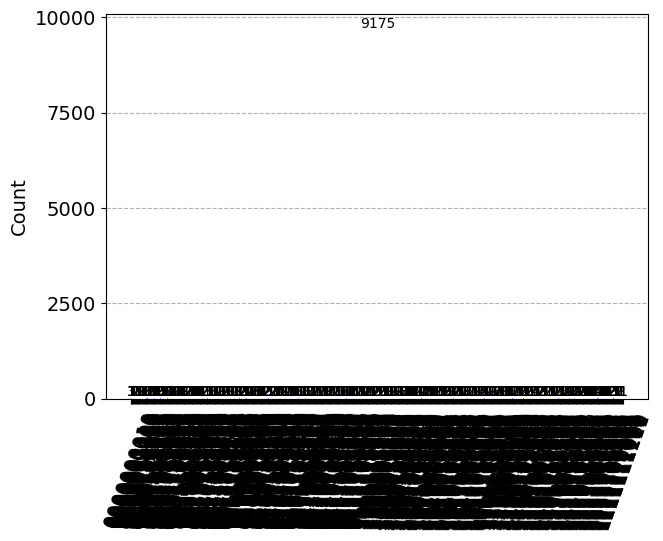

In [207]:
print('Number of qubits', n)
print('Number of ancillas', 2*(n)-3-n)
print('Total number of qubits', 2*(n)-3)
print('Search space size', 2**n)
print('With target',Target_string)

print('\nInteractions of Grover to perform', N_iterations)
print('Optimal number of iterations', int((np.pi/2*np.sqrt(N)-1)/2))
print()

x = counts_q.keys()
y = counts_q.values()
# top 5 x associate with the 5 larges value of y
top_x = [x for _,x in sorted(zip(y,x), reverse=True)][:5]
top_y = sorted(y, reverse=True)[:5]

print('Top 5 x associate with the 5 larges value of y')
print(top_x)
print(top_y)

plot_histogram(counts_q)